In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy import genfromtxt
import numpy as np
import csv
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
training_data = genfromtxt('training.csv',dtype = str, delimiter=',')
testing_data = genfromtxt('testing.csv',dtype = str, delimiter=',')

In [3]:
train_labels = training_data[1:,-1]
train_labels = (train_labels == 's').astype(np.int32)
train_weights = training_data[1:,31].astype(np.float32)
train_data = training_data[1:,1:31]
train_data = train_data.astype(np.float32)

In [4]:
test_labels = testing_data[1:,-1]
test_labels = (test_labels == 's').astype(np.int32)
test_weights = testing_data[1:,31].astype(np.float32)
test_data = testing_data[1:,1:31]
test_data = test_data.astype(np.float32)

In [5]:
def normalize_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    return data

def replace_missing_values(data):
    a, b = np.where(data == -999)
    new_r, new_c = np.where(data != -999)
    mean_list = np.mean(data[new_r][new_c], axis = 0)
    for i in range(len(a)):
        data[a[i]][data[a[i]] == -999] = mean_list[b[i]]
    x, y = np.where(data == -999)
    print(x,y)
    return data
    
def run_pca(data):
    pca = PCA(n_components=25)
    pca.fit(data)
    data = pca.transform(data)
    return data

In [ ]:
train_data = replace_missing_values(train_data)
test_data = replace_missing_values(test_data)

train_data = normalize_data(train_data)
test_data = normalize_data(test_data)

# train_data = run_pca(train_data)
# test_data = run_pca(test_data)

print(train_data.shape)
print(test_data.shape)

In [6]:
import math
def calc_ams(w,y,p):
    w = np.asarray(w)
    y = np.asarray(y)
    p = np.asarray(p)
    y_signal = w * (y == 1)
    y_background = w * (y == 0)
    s = np.sum(y_signal * (p == 1))
    b = np.sum(y_background * (p == 1))
    b_r=10.0
    a = np.sqrt( 2 * ((s + b + b_r) * math.log ( 1.0 + (s / (b + b_r) ) ) - s ))
    return a

In [7]:
from sklearn.metrics import precision_score, recall_score
def precision(labels, pred):
    precision = precision_score(labels,pred)
    return precision

def recall(labels, pred):
    recall = recall_score(labels,pred)
    return recall

In [8]:
from sklearn.linear_model import LogisticRegression
def run_lr(train_data,train_labels,test_data,test_labels,weights):
    clf = LogisticRegression(random_state=0, solver='lbfgs')
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict_proba(test_data)[:,1]
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("Logistic Regression:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_lr(train_data,train_labels,test_data,test_labels,test_weights)

In [9]:
from sklearn.naive_bayes import GaussianNB

def run_gnb(train_data,train_labels,test_data,test_labels,weights):
    clf = GaussianNB()
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict_proba(test_data)[:,1]
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("Gaussian Naive Bayes:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_gnb(train_data,train_labels,test_data,test_labels,test_weights)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

def run_gradient_boosting(train_data,train_labels,test_data,test_labels,weights):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=6, random_state=0)
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("Gradient Boosting Classifier:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_gradient_boosting(train_data,train_labels,test_data,test_labels,test_weights)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

def run_gradient_boosting_depth(train_data,train_labels,test_data,test_labels,weights):
    acc_list = []
    depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    for i in range(1, 21):
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=6, random_state=0)
        clf.fit(train_data, train_labels)
        acc = clf.score(test_data,test_labels)
        print(acc)
        acc_list.append(acc)

    plt.clf()
    plt.plot(depth, acc_list)
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    plt.title('depth_vs_accuracy_GradientBossting')
    plt.savefig('Gradient_Boosting_depth_vs_accuracy.png')

# run_gradient_boosting_depth(train_data,train_labels,test_data,test_labels,test_weights)

In [12]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree(train_data,train_labels,test_data,test_labels,weights):
    clf = DecisionTreeClassifier(random_state=0)
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("Decision Tree Classifier:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_decision_tree(train_data,train_labels,test_data,test_labels,test_weights)

In [13]:
from sklearn.tree import DecisionTreeClassifier
def run_decision_tree_depth(train_data,train_labels,test_data,test_labels,weights):
    acc_list = []
    depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    for i in range(1, 21):
        clf = DecisionTreeClassifier(criterion = "entropy", random_state=0, max_depth = i, min_impurity_decrease = 0.000009)
        clf.fit(train_data, train_labels)
        acc = clf.score(test_data,test_labels)
        print(acc)
        acc_list.append(acc)

    plt.clf()
    plt.plot(depth, acc_list)
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    plt.title('depth_vs_accuracy_decisionTree')
    plt.savefig('decision_depth_vs_accuracy.png')

# run_decision_tree_depth(train_data,train_labels,test_data,test_labels,test_weights)

In [14]:
from xgboost import XGBClassifier
def run_xgboost(train_data,train_labels,test_data,test_labels,weights):
    clf = XGBClassifier()
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("XG Boost Classifier:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    
    fpr_xgb, tpr_lr, _ = metrics.roc_curve(labels, preds_lr)

    plt.plot(fpr_lr, tpr_lr)
    plt.plot(fpr_gnb, tpr_gnb)
    plt.plot(fpr_gb, tpr_gb)
    plt.plot(fpr_xgb, tpr_xgb)
    plt.plot(fpr_rf, tpr_rf)
    plt.plot(fpr_dt, tpr_dt)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    return preds

run_xgboost(train_data,train_labels,test_data,test_labels,test_weights)

In [15]:
from sklearn.ensemble import RandomForestClassifier
def run_random_forest(train_data,train_labels,test_data,test_labels,weights):
    clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
    clf = clf.fit(train_data, train_labels)
    preds = clf.predict(test_data)
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("Random Forest Classifier:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_random_forest(train_data,train_labels,test_data,test_labels,test_weights)

In [16]:
import lightgbm as lgb

def run_light_gbm(train_data,train_labels,test_data,test_labels,weights):
    lgb_new=lgb.LGBMClassifier( boosting_type='gbdt', num_leaves=30, max_depth=5, learning_rate=0.1, n_estimators=50, nthread=10, max_bin=225, objective=None, min_split_gain=0, 
    min_child_weight=5, 
    min_child_samples=10, subsample=1, subsample_freq=1, 
    colsample_bytree=1, 
    reg_alpha=1, reg_lambda=0, seed=410,silent=True);
    clf=lgb_new.fit(train_data, train_labels);
    preds = clf.predict(test_data)
    preds[preds<0.6] = 0
    preds[preds>=0.6] = 1
    print("LightGBM Classifier:")
    print("Accuracy: ", clf.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

# run_light_gbm(train_data,train_labels,test_data,test_labels,test_weights)

ImportError: No module named lightgbm

In [ ]:
from sklearn.ensemble import BaggingClassifier

def run_bagging_dt(train_data,train_labels,test_data,test_labels,weights):
    clfDT = DecisionTreeClassifier(random_state=0 , max_depth = 6)
    bagDT=BaggingClassifier(base_estimator=clfDT,n_estimators=100, random_state = 200)
    bagDT=bagDT.fit(train_data, train_labels)
    preds = bagDT.predict(test_data)
    preds[preds<0.5] = 0
    preds[preds>=0.5] = 1
    print("Bagging Classifier(Decison Tree):")
    print("Accuracy: ", bagDT.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

run_bagging_dt(train_data,train_labels,test_data,test_labels,test_weights)

In [ ]:
from sklearn.ensemble import BaggingClassifier

def run_bagging_lr(train_data,train_labels,test_data,test_labels,weights):
    clfLR = LogisticRegression(random_state=0, solver='lbfgs')
    bagLR=BaggingClassifier(base_estimator=clfLR,n_estimators=100, random_state = 200)
    bagLR=bagLR.fit(train_data, train_labels)
    preds = bagLR.predict(test_data)
    preds[preds<0.5] = 0
    preds[preds>=0.5] = 1
    print("Bagging Classifier(Logistic Regression):")
    print("Accuracy: ", bagLR.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

run_bagging_lr(train_data,train_labels,test_data,test_labels,test_weights)

In [ ]:
from sklearn.ensemble import BaggingClassifier

def run_bagging_gnb(train_data,train_labels,test_data,test_labels,weights):
    clfGNB = GaussianNB()
    bagGNB=BaggingClassifier(base_estimator=clfGNB,n_estimators=100, random_state = 200)
    bagGNB=bagGNB.fit(train_data, train_labels)
    preds = bagGNB.predict(test_data)
    preds[preds<0.5] = 0
    preds[preds>=0.5] = 1
    print("Bagging Classifier(Gaussian Naive Bayes):")
    print("Accuracy: ", bagGNB.score(test_data,test_labels))
    print("AMS score: ", calc_ams(weights.astype(np.float32),test_labels,preds))
    print("Precision: ", precision(test_labels,preds))
    print("Recall: ", recall(test_labels,preds))
    return preds

run_bagging_gnb(train_data,train_labels,test_data,test_labels,test_weights)

In [ ]:
# calculate Pearson's correlation
from scipy.stats import pearsonr
n = len(train_data[0])
dict1={}
for i in range(1,n-2):
    l= []
    for j in range(1,n-2):
        corr, _ = pearsonr(train_data[:,i], train_data[:,j])
        l.append(corr)
    dict1[training_data[0][i]]=l

dataframe = pd.DataFrame.from_dict(dict1, orient='index',columns=training_data[0][1:n-2])


#check for relations where there is 0.95 correlation
dict2={}
for key in dict1:
    n = len(dict1[key])
    for i in range(0,n):
        if dict1[key][i]>=0.95 and key!=training_data[0][i+1]:
            if key>training_data[0][i+1]:
                a = training_data[0][i+1]
                b = key
            else:
                a = key
                b = training_data[0][i+1]
            dict2[(a,b)]=dict1[key][i]

for key in dict2:
    print (key,dict2[key])

In [ ]:
dataCsv = dataframe.to_csv(index=True)
f = open('correlation.csv','w+')
f.write(dataCsv)

In [ ]:
# Plot of DER_mass_MC
import random
import numpy
from matplotlib import pyplot

filename='training.csv'
data = genfromtxt(filename,dtype = float, delimiter=',');
data1 = genfromtxt(filename,dtype = str, delimiter=',');
Mass = data[1:,1]
Y = data1[1:,32]
Y = np.array(Y)

Mass = np.array(Mass)
Msignal = Mass[Y=='s'];
Mbackground = Mass[Y=='b'];
bins = numpy.linspace(9, 500, 50)
pyplot.hist(Mbackground, bins, alpha=0.5, label='Background')
pyplot.hist(Msignal, bins, alpha=0.5, label='Signal')
pyplot.legend(loc='upper right')
pyplot.xlabel('DER_mass_MMC')
pyplot.ylabel('Number of events')
pyplot.show()

In [ ]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(train_data[:200000], train_labels[:200000])
clf.score(train_data[200000:], train_labels[200000:])

In [ ]:
#experimenting on different parameters of svm
from sklearn import svm
X,Y = train_data,train_labels
W = training_data[1:,31]
W = W.astype(np.float64)

X1 = X[:100000];
W1 = W[:100000];
Y1 = Y[:100000];
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']

print("\nExperimenting for different kernels")
for kernel in kernels:
    svc= svm.SVC(kernel=kernel).fit(X1,Y1)
#     plotSVC('kernel=' + str(kernel))
    svmScore = svc.score(X[100000:200000],Y[100000:200000])
    print("Kernel ", kernel," Svm score for test data:",svmScore)
    
print("\nExperimenting for different gammas")
for gamma in gammas:
    svc = svm.SVC(kernel='rbf', gamma=gamma).fit(X, Y)
    svmScore = svc.score(X[100000:200000],Y[100000:200000])
#     plotSVC(‘gamma=’ + str(gamma))
    print("Gamma:", gamma," Svm score for test data:",svmScore)
    
print("\nExperimenting for different Regularization parameters")
for c in Cs:
    svc = svm.SVC(kernel='rbf', C=c).fit(X, Y)
    svmScore = svc.score(X[100000:200000],Y[100000:200000])
#     plotSVC(‘C=’ + str(c))
    print("C:", c," Svm score for test data:",svmScore)

print("\nExperimenting for different Degrees for polynomial kernel")
degrees = [0, 1, 2, 3, 4]
for degree in degrees:
    svc = svm.SVC(kernel='poly', degree=degree).fit(X, Y)
    svmScore = svc.score(X[100000:200000],Y[100000:200000])
    print("Degree ", degree," Svm score for test data:",svmScore)
    

In [17]:
def process_data_jet_num(train_data,train_labels,num,weights):
    if num == 0:
        data = train_data[train_data[:,22] == 0]
        data = np.delete(data,[4,5,6,12,22,23,24,25,26,27,28],1)
        labels = train_labels[np.where(train_data[:,22] == 0)]
        weights = weights[np.where(train_data[:,22] == 0)]
    elif num == 1:
        data = train_data[train_data[:,22] == 1]
        data = np.delete(data,[4,5,6,12,26,27,28,22],1)
        labels = train_labels[np.where(train_data[:,22] == 1)]
        weights = weights[np.where(train_data[:,22] == 1)]
    else:
        data_2 = train_data[train_data[:,22] == 2]
        data_2 = np.delete(data_2,[22],1)
        labels_2 = train_labels[np.where(train_data[:,22] == 2)]
        labels_2_weights = weights[np.where(train_data[:,22] == 2)]

        data_3 = train_data[train_data[:,22] == 3]
        data_3 = np.delete(data_3,[22],1)
        labels_3 = train_labels[np.where(train_data[:,22] == 3)]
        labels_3_weights = weights[np.where(train_data[:,22] == 3)]
        
        data = np.concatenate((data_2,data_3),axis=0)
        labels = np.concatenate((labels_2,labels_3),axis=0)
        weights = np.concatenate((labels_2_weights,labels_3_weights),axis=0)
    return data, labels, weights

In [29]:
def merge_jet_num(preds_0, preds_1, preds_2_3, test_0_labels, test_1_labels, test_2_3_labels, test_0_weights, test_1_weights, test_2_3_weights):
    preds = np.concatenate((preds_0,preds_1,preds_2_3))
    labels = np.concatenate((test_0_labels,test_1_labels,test_2_3_labels))
    weights = np.concatenate((test_0_weights,test_1_weights,test_2_3_weights))
    print(preds.shape)
    print(labels.shape)
    print(weights.shape)
    print("jet-num-merged: ")
    print("Accuracy: ", accuracy_score(labels,preds))
    print("AMS score: ", calc_ams(weights.astype(np.float32),labels,preds))
    print("Precision: ", precision(labels,preds))
    print("Recall: ", recall(labels,preds))
    return preds

In [19]:
data_jet_num_0, data_jet_num_0_labels, data_jet_num_0_weights = process_data_jet_num(train_data,train_labels,0,train_weights)
data_jet_num_0 = normalize_data(data_jet_num_0)

data_jet_num_1, data_jet_num_1_labels, data_jet_num_1_weights = process_data_jet_num(train_data,train_labels,1,train_weights)
data_jet_num_1 = normalize_data(data_jet_num_1)

data_jet_num_2_3, data_jet_num_2_3_labels, data_jet_num_2_3_weights = process_data_jet_num(train_data,train_labels,2,train_weights)
data_jet_num_2_3 = normalize_data(data_jet_num_2_3)

data_jet_num_0_test, data_jet_num_0_test_labels, data_jet_num_0_test_weights = process_data_jet_num(test_data,test_labels,0,test_weights)
data_jet_num_0_test = normalize_data(data_jet_num_0_test)

data_jet_num_1_test, data_jet_num_1_test_labels, data_jet_num_1_test_weights = process_data_jet_num(test_data,test_labels,1,test_weights)
data_jet_num_1_test = normalize_data(data_jet_num_1_test)

data_jet_num_2_3_test, data_jet_num_2_3_test_labels, data_jet_num_2_3_test_weights = process_data_jet_num(test_data,test_labels,2,test_weights)
data_jet_num_2_3_test = normalize_data(data_jet_num_2_3_test)

In [ ]:
from sklearn.ensemble import VotingClassifier

lr = LogisticRegression(random_state=0, solver='lbfgs')
xgb = XGBClassifier()
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
ensemble =VotingClassifier(estimators=[('lr',lr),('rf',rf),('xgb',xgb)],voting='hard')
ensemble.fit(data_jet_num_0,data_jet_num_0_labels)
preds_0 = ensemble.predict(data_jet_num_0_test)

ensemble.fit(data_jet_num_1,data_jet_num_1_labels)
preds_1 = ensemble.predict(data_jet_num_1_test)

ensemble.fit(data_jet_num_2_3,data_jet_num_2_3_labels)
preds_2_3 = ensemble.predict(data_jet_num_2_3_test)

merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

In [30]:
preds_0 = run_lr(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_lr(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_lr(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_lr = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

Logistic Regression:
('Accuracy: ', 0.82562933501479363)
('AMS score: ', 1.6537014145576556)
('Precision: ', 0.75466151762298628)
('Recall: ', 0.41919062560030734)
Logistic Regression:
('Accuracy: ', 0.71278151352994512)
('AMS score: ', 0.65372817682042028)
('Precision: ', 0.67041953938682708)
('Recall: ', 0.2688659126674805)
Logistic Regression:
('Accuracy: ', 0.73471677572014171)
('AMS score: ', 0.77862687011889753)
('Precision: ', 0.78496806821957255)
('Recall: ', 0.5276754141075749)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.75218079797876869)
('AMS score: ', 1.8836174595978341)
('Precision: ', 0.74902062077575449)
('Recall: ', 0.41218918201804261)


In [31]:
preds_0 = run_gnb(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_gnb(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_gnb(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_gnb = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

Gaussian Naive Bayes:
('Accuracy: ', 0.78615543806890753)
('AMS score: ', 1.3467126831669531)
('Precision: ', 0.57417399659989654)
('Recall: ', 0.746110008324262)
Gaussian Naive Bayes:
('Accuracy: ', 0.72481511957609845)
('AMS score: ', 0.87163555926717706)
('Precision: ', 0.63216519851908592)
('Recall: ', 0.58261879899401414)
Gaussian Naive Bayes:
('Accuracy: ', 0.71502605063488012)
('AMS score: ', 0.88974163757599323)
('Precision: ', 0.67473451937663775)
('Recall: ', 0.72845710031639677)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.75407165860341585)
('AMS score: ', 1.8030650511042388)
('Precision: ', 0.6278189300411523)
('Recall: ', 0.6866992646501402)


In [32]:
preds_0 = run_gradient_boosting(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_gradient_boosting(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_gradient_boosting(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_gb = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

Gradient Boosting Classifier:
('Accuracy: ', 0.80994244232106194)
('AMS score: ', 1.2249141273099067)
('Precision: ', 0.64155196745047005)
('Recall: ', 0.56036690785682264)
Gradient Boosting Classifier:
('Accuracy: ', 0.79312260546438917)
('AMS score: ', 1.0556420758908343)
('Precision: ', 0.71313913342400648)
('Recall: ', 0.70174870942597034)
Gradient Boosting Classifier:
('Accuracy: ', 0.82617172311896647)
('AMS score: ', 1.1477614994618941)
('Precision: ', 0.80899017248295224)
('Recall: ', 0.80076927849122159)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.80947759516172602)
('AMS score: ', 1.9029364775307285)
('Precision: ', 0.73172634487145083)
('Recall: ', 0.69771529830945345)


In [33]:
preds_0 = run_decision_tree(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_decision_tree(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_decision_tree(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_dt = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

Decision Tree Classifier:
('Accuracy: ', 0.78227514510678886)
('AMS score: ', 1.0314514084335835)
('Precision: ', 0.56504249463146117)
('Recall: ', 0.5981302426842543)
Decision Tree Classifier:
('Accuracy: ', 0.75647146997625769)
('AMS score: ', 0.89464551737872977)
('Precision: ', 0.6539693892147046)
('Recall: ', 0.67240745370846999)
Decision Tree Classifier:
('Accuracy: ', 0.79396669517979934)
('AMS score: ', 0.99335514165858751)
('Precision: ', 0.77017190838177574)
('Recall: ', 0.76934052980954148)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.77771631267620667)
('AMS score: ', 1.5947529594499446)
('Precision: ', 0.67001625535687892)
('Recall: ', 0.68743840497308772)


In [34]:
preds_0 = run_xgboost(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_xgboost(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_xgboost(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_xgb = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

XG Boost Classifier:
('Accuracy: ', 0.84879791757611034)
('AMS score: ', 1.7455319855054277)
('Precision: ', 0.74227541668277974)
('Recall: ', 0.61453864378561829)
XG Boost Classifier:
('Accuracy: ', 0.81718457643907982)
('AMS score: ', 1.2320488866949832)
('Precision: ', 0.75827587282768083)
('Recall: ', 0.71488241436618472)
XG Boost Classifier:
('Accuracy: ', 0.84435162247131101)
('AMS score: ', 1.260885434901365)
('Precision: ', 0.82942540259414754)
('Recall: ', 0.82119238166139341)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.83774668937640417)
('AMS score: ', 2.4506192919171368)
('Precision: ', 0.78306878306878303)
('Recall: ', 0.72577894018649081)


In [35]:
preds_0 = run_random_forest(data_jet_num_0,data_jet_num_0_labels,data_jet_num_0_test,data_jet_num_0_test_labels,data_jet_num_0_test_weights)
preds_1 = run_random_forest(data_jet_num_1,data_jet_num_1_labels,data_jet_num_1_test,data_jet_num_1_test_labels,data_jet_num_1_test_weights)
preds_2_3 = run_random_forest(data_jet_num_2_3,data_jet_num_2_3_labels,data_jet_num_2_3_test,data_jet_num_2_3_test_labels,data_jet_num_2_3_test_weights)
preds_rf = merge_jet_num(preds_0,preds_1,preds_2_3,data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels,data_jet_num_0_test_weights,data_jet_num_1_test_weights,data_jet_num_2_3_test_weights)

Random Forest Classifier:
('Accuracy: ', 0.84781167644823852)
('AMS score: ', 1.7701724230057627)
('Precision: ', 0.75606736007924713)
('Recall: ', 0.58647627585323681)
Random Forest Classifier:
('Accuracy: ', 0.80697487932326695)
('AMS score: ', 1.1989548114983413)
('Precision: ', 0.74815263090839601)
('Recall: ', 0.69092406571264686)
Random Forest Classifier:
('Accuracy: ', 0.83845273670528897)
('AMS score: ', 1.3051331014106613)
('Precision: ', 0.82460960639249836)
('Recall: ', 0.81179973943793038)
(618237,)
(618237,)
(618237,)
jet-num-merged: 
('Accuracy: ', 0.83248333567871224)
('AMS score: ', 2.4593127922297748)
('Precision: ', 0.78199390317486139)
('Recall: ', 0.70616803123341676)


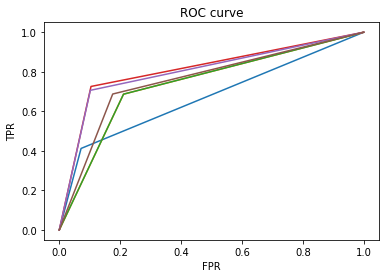

In [37]:
labels = np.concatenate((data_jet_num_0_test_labels,data_jet_num_1_test_labels,data_jet_num_2_3_test_labels))

fpr_lr, tpr_lr, _ = metrics.roc_curve(labels, preds_lr)
fpr_gnb, tpr_gnb, _ = metrics.roc_curve(labels, preds_gnb)
fpr_gb, tpr_gb, _ = metrics.roc_curve(labels, preds_gnb)
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(labels, preds_xgb)
fpr_rf, tpr_rf, _ = metrics.roc_curve(labels, preds_rf)
fpr_dt, tpr_dt, _ = metrics.roc_curve(labels, preds_dt)

plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_gnb, tpr_gnb)
plt.plot(fpr_gb, tpr_gb)
plt.plot(fpr_xgb, tpr_xgb)
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_dt, tpr_dt)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
def extract_weighted_columns(data):
    data = data[:,[1,2,4,6,8,9,10,15,17,18,21,25,27,28,29]]
    return data

In [ ]:
train_data_weighted = normalize_data(replace_missing_values(extract_weighted_columns(train_data)))
test_data_weighted = normalize_data(replace_missing_values(extract_weighted_columns(test_data)))

In [ ]:
run_lr(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)

In [ ]:
run_gnb(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)

In [ ]:
run_gradient_boosting(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)

In [ ]:
run_decision_tree(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)

In [ ]:
run_xgboost(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)

In [ ]:
run_random_forest(train_data_weighted,train_labels,test_data_weighted,test_labels,test_weights)